In [89]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm

from utils.neural_network import train_nn, get_device

from models.KF import KF, apply_kalman_filter
from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [90]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [91]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [92]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cpu device


100%|██████████| 100/100 [00:01<00:00, 52.76it/s]


Final training loss: 0.01687462255358696
Final validation loss: 0.5011292695999146
Final validation R^2: 0.3338476794422509


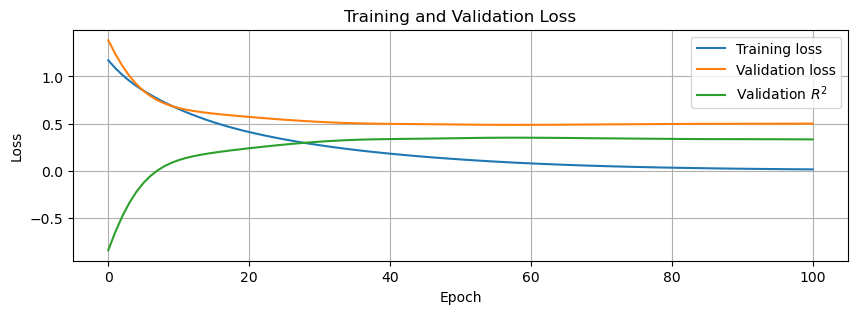

In [93]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

In [94]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [95]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [96]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country, predictions_melted=predictions_melted):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]

    plt.figure(figsize=(12, 6), dpi=300)

    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(predictions_melted))

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Using the Kalman Filter on high frequency data

In [97]:
# Utility function to apply and plot the Kalman filter
def apply_and_plot_kalman_filter(model, preprocessor, use_true_values, accurate_noise_var, accel_var):
    kf_predictions_melted, hf_data_melted, kf_r2, kf_smoothness = apply_kalman_filter(model, preprocessor, use_true_values=use_true_values, seed=SEED, accurate_noise_var=accurate_noise_var, accel_var=accel_var)

    all_predictions_merged = pd.concat([predictions_melted[predictions_melted['Type'] != 'y_pred'], kf_predictions_melted, hf_data_melted], ignore_index=True)

    # Create a dropdown widget for selecting the country
    countries = all_predictions_merged["country"].unique()
    dropdown = widgets.Dropdown(
        options=countries,
        value=countries[0],
        description='Country:'
    )

    mask_type = lambda df, type: df[df['Type'] == type]
    print(f"R2 for Kalman Filter: {kf_r2}, smoothness: {kf_smoothness[1]}")
    for col in ['y_pred', 'y_true']:
        means = results.measure_smoothness(mask_type(all_predictions_merged, col)['Value'].values, mask_type(all_predictions_merged, col)['date'], mask_type(all_predictions_merged, col)['country'])
        print(f"Geometric mean of smoothness metrics on {col}: {means[1]}")

    # Use the interact function to link the dropdown with the plot function
    interact(plot_by_country, selected_country=dropdown, predictions_melted=widgets.fixed(all_predictions_merged))
    plt.show()

    # Return for paper plots
    return all_predictions_merged

In [98]:
apply_and_plot_kalman_filter(model, preprocessor, use_true_values=False, accurate_noise_var=0, accel_var=8e-6)

R2 for Kalman Filter: 0.7030537580357181, smoothness: 0.217171016008765
Geometric mean of smoothness metrics on y_pred: 0.636765182738523
Geometric mean of smoothness metrics on y_true: 0.7389002587478799


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

,date,country,Set,Type,Value
0,2006-03-01,Canada,Training,y_true,0.849201
1,2006-03-01,Germany,Training,y_true,0.542476
2,2006-03-01,Korea,Training,y_true,0.995910
3,2006-03-01,Switzerland,Training,y_true,1.543956
4,2006-03-01,United Kingdom,Training,y_true,0.643475
...,...,...,...,...,...
4922,2024-05-01,Japan,High Frequency,y_pred,0.497527
4923,2024-05-01,Korea,High Frequency,y_pred,0.943671
4924,2024-05-01,Switzerland,High Frequency,y_pred,0.701928
4925,2024-05-01,United Kingdom,High Frequency,y_pred,-0.038548


### Passing true values through the filter when available to correct the estimate

In [99]:
apply_and_plot_kalman_filter(model, preprocessor, use_true_values=True, accurate_noise_var=5e-4, accel_var=8e-6)

R2 for Kalman Filter: 0.989922475947094, smoothness: 0.5013820945138601
Geometric mean of smoothness metrics on y_pred: 0.636765182738523
Geometric mean of smoothness metrics on y_true: 0.7389002587478799


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

,date,country,Set,Type,Value
0,2006-03-01,Canada,Training,y_true,0.849201
1,2006-03-01,Germany,Training,y_true,0.542476
2,2006-03-01,Korea,Training,y_true,0.995910
3,2006-03-01,Switzerland,Training,y_true,1.543956
4,2006-03-01,United Kingdom,Training,y_true,0.643475
...,...,...,...,...,...
4922,2024-05-01,Japan,High Frequency,y_pred,0.497527
4923,2024-05-01,Korea,High Frequency,y_pred,0.943671
4924,2024-05-01,Switzerland,High Frequency,y_pred,0.701928
4925,2024-05-01,United Kingdom,High Frequency,y_pred,-0.038548


### Exploring noise variances

  0%|          | 0/100 [00:00<?, ?it/s]

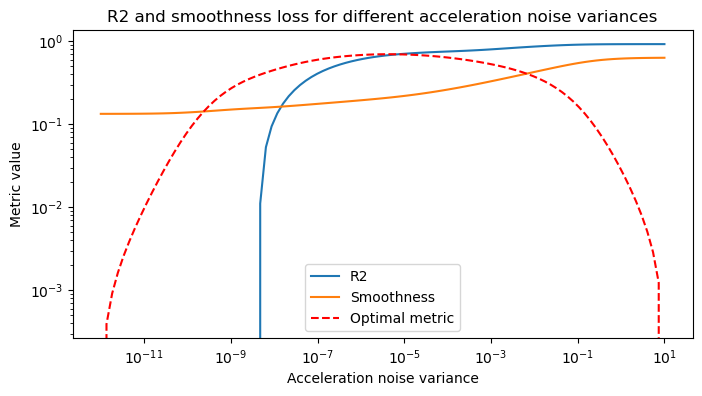

In [100]:
variances = np.logspace(-12, 1, 100)

r2s = np.zeros(len(variances))
smoothness_losses = np.zeros(len(variances))
                        
for accel_var_idx, acceleration_noise_variance in tqdm(enumerate(variances), total=len(variances)):
    kf_predictions_melted, hf_data_melted, kf_r2, kf_smoothness = apply_kalman_filter(model, preprocessor, use_true_values=False, seed=SEED, accurate_noise_var=0, accel_var=acceleration_noise_variance)
    r2s[accel_var_idx] = kf_r2
    smoothness_losses[accel_var_idx] = kf_smoothness[1] # keep the geometric mean only

optimal_metric = (r2s - np.min(r2s)) / (np.max(r2s) - np.min(r2s)) - (smoothness_losses - np.min(smoothness_losses)) / (np.max(smoothness_losses) - np.min(smoothness_losses))

plt.figure(figsize=(8, 4))
plt.title("R2 and smoothness loss for different acceleration noise variances")
plt.plot(variances, r2s, label="R2")
plt.plot(variances, smoothness_losses, label="Smoothness")
plt.plot(variances, optimal_metric, label="Optimal metric", color="red", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Acceleration noise variance")
plt.ylabel("Metric value")
plt.legend()
plt.show()

Finding the best value:

In [101]:
OPTIMAL_ACCEL_VAR = variances[np.argmax(optimal_metric)]
print(f"Optimal acceleration noise variance: {OPTIMAL_ACCEL_VAR}")

Optimal acceleration noise variance: 4.977023564332114e-06


In [102]:
predictions_merged = apply_and_plot_kalman_filter(model, preprocessor, use_true_values=False, accurate_noise_var=0, accel_var=OPTIMAL_ACCEL_VAR)

R2 for Kalman Filter: 0.6876789093780805, smoothness: 0.21128085905147512
Geometric mean of smoothness metrics on y_pred: 0.636765182738523
Geometric mean of smoothness metrics on y_true: 0.7389002587478799


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Exploring noise variance values using true GDP values

In [103]:
variances = np.logspace(-12, 2, 25)

r2s = np.zeros((len(variances), len(variances)))
smoothness_losses = np.zeros((len(variances), len(variances)))
                        
for accel_var_idx, acceleration_noise_variance in tqdm(enumerate(variances), total=len(variances)):
    for true_gdp_var_idx, true_gdp_noise_variance in tqdm(enumerate(variances), total=len(variances), leave=False):
        kf_predictions_melted, hf_data_melted, kf_r2, kf_smoothness = apply_kalman_filter(model, preprocessor, use_true_values=True, seed=SEED, accurate_noise_var=true_gdp_noise_variance, accel_var=acceleration_noise_variance)
        r2s[accel_var_idx, true_gdp_var_idx] = kf_r2
        smoothness_losses[accel_var_idx, true_gdp_var_idx] = kf_smoothness[1] # keep the geometric mean only
        # x is the acceleration variance, y is the true gdp variance

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

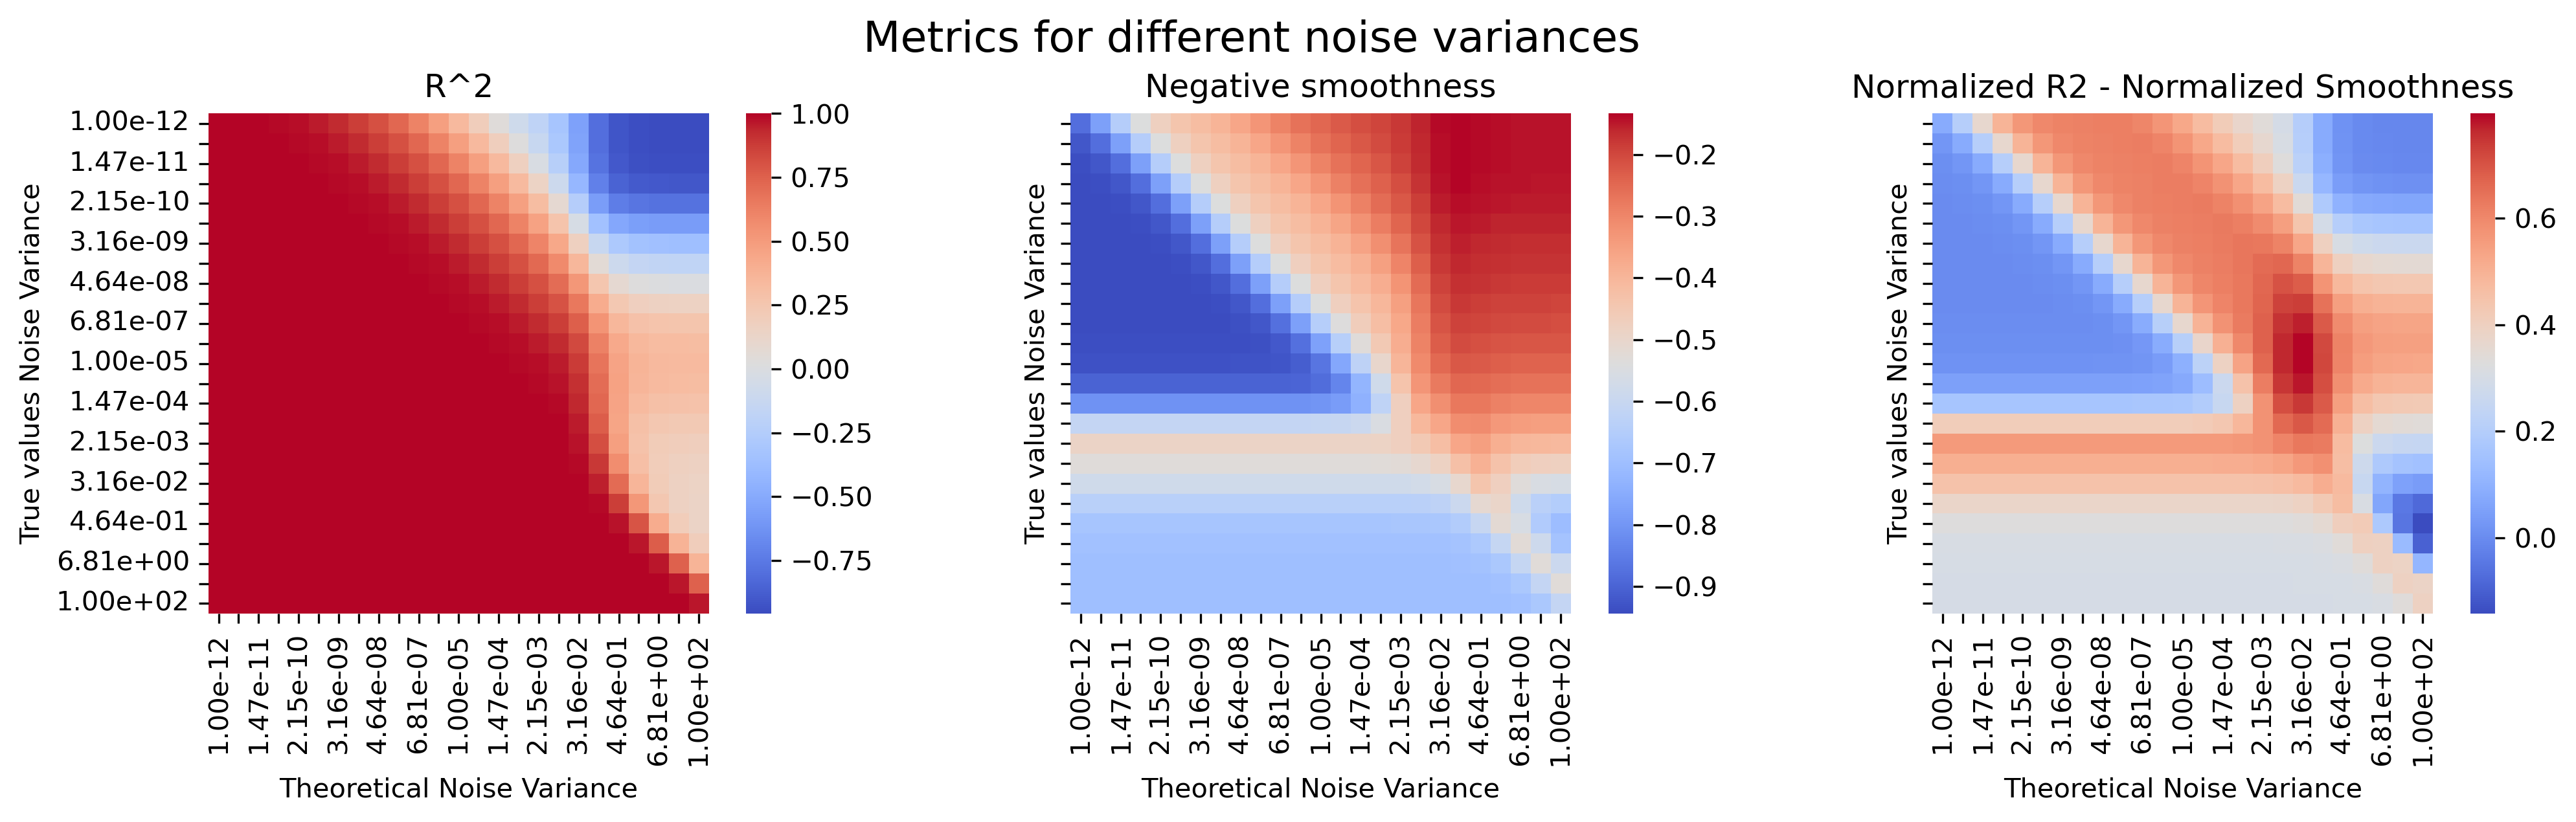

In [132]:
# combination of both
normalized_r2s = (r2s - r2s.min()) / (r2s.max() - r2s.min())
normalized_smoothness_losses = (smoothness_losses - smoothness_losses.min()) / (smoothness_losses.max() - smoothness_losses.min())
optimal_metric = normalized_r2s - normalized_smoothness_losses

def noise_variance_heatmap(r2s, smoothness_losses, optimal_metric, variances, file_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True, sharex=True, dpi=300)
    fig.suptitle("Metrics for different noise variances", fontsize=16)

    for ax in axes:
        ax.set_box_aspect(1)

    ticklabels = [f'{v:.2e}' if i % 2 == 0 else '' for i, v in enumerate(variances)] # show every second label

    # heatmap for R2
    sns.heatmap(r2s, annot=False, fmt=".2f", xticklabels=ticklabels, yticklabels=ticklabels, cmap="coolwarm", ax=axes[0])
    axes[0].set_title("R^2")
    axes[0].set_xlabel("Theoretical Noise Variance")
    axes[0].set_ylabel("True values Noise Variance")

    # heatmap for smoothness
    sns.heatmap(-smoothness_losses, annot=False, fmt=".2f", xticklabels=ticklabels, yticklabels=ticklabels, cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Negative smoothness")
    axes[1].set_xlabel("Theoretical Noise Variance")
    axes[1].set_ylabel("True values Noise Variance")

    # heatmap for the optimal metric
    sns.heatmap(optimal_metric, annot=False, fmt=".2f", xticklabels=ticklabels, yticklabels=ticklabels, cmap="coolwarm", ax=axes[2])
    axes[2].set_title("Normalized R2 - Normalized Smoothness")
    axes[2].set_xlabel("Theoretical Noise Variance")
    axes[2].set_ylabel("True values Noise Variance")

    if file_path:
        plt.savefig(file_path, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

noise_variance_heatmap(r2s, smoothness_losses, optimal_metric, variances)

We find the optimal parameters :

In [105]:
optimal_indices = np.unravel_index(np.argmax(optimal_metric, axis=None), optimal_metric.shape)
OPTIMAL_ACCURATE_NOISE_VAR = variances[optimal_indices[1]]
OPTIMAL_ACCEL_VAR = variances[optimal_indices[0]]

print(f"Optimal acceleration noise variance: {OPTIMAL_ACCEL_VAR:.2e}")
print(f"Optimal true GDP noise variance: {OPTIMAL_ACCURATE_NOISE_VAR:.2e}")

Optimal acceleration noise variance: 1.00e-05
Optimal true GDP noise variance: 3.16e-02


In [106]:
predictions_merged_true_value = apply_and_plot_kalman_filter(model, preprocessor, use_true_values=True, accurate_noise_var=OPTIMAL_ACCURATE_NOISE_VAR, accel_var=OPTIMAL_ACCEL_VAR)

R2 for Kalman Filter: 0.8833910111877948, smoothness: 0.250492594186667
Geometric mean of smoothness metrics on y_pred: 0.636765182738523
Geometric mean of smoothness metrics on y_true: 0.7389002587478799


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Paper plot

In [107]:
#plt.style.use('ieee.mplstyle') # TODO use latex

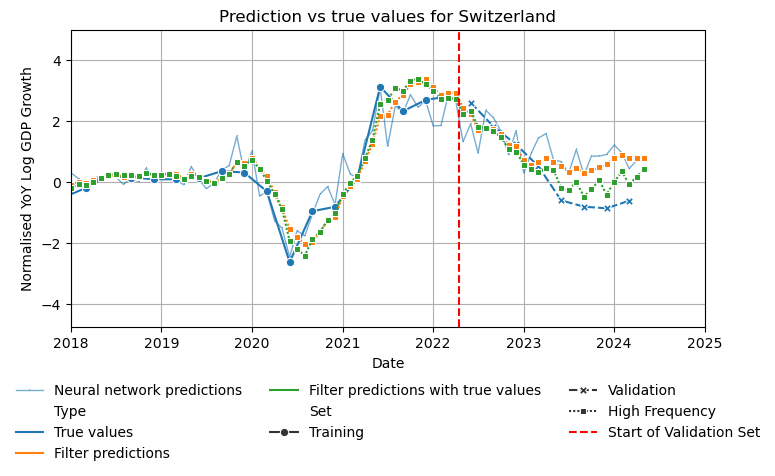

In [108]:
SELECTED_COUNTRY = 'Switzerland'

# Prepare the data
type_mapping = {
    'y_pred': 'Neural network predictions',
    'y_kf': 'Filter predictions',
    'y_true': 'True values'
}

plot_data = predictions_merged.copy()
plot_data['Type'] = plot_data['Type'].apply(lambda x: type_mapping[x])
true_values = predictions_merged_true_value.loc[predictions_merged_true_value['Type'] == 'y_kf'].assign(Type='Filter predictions with true values')
plot_data = pd.concat([plot_data, true_values], ignore_index=True)

# Cutoff date
cutoff_date = (preprocessor.dates_valid.values[0] - preprocessor.dates_train.values[-1]) / 2 + preprocessor.dates_train.values[-1]

filtered_data = plot_data[(plot_data["country"] == SELECTED_COUNTRY) & (plot_data["Type"] != "Neural network predictions")]
high_freq_predictions = plot_data[(plot_data["country"] == SELECTED_COUNTRY) & (plot_data["Type"] == "Neural network predictions")]

plt.figure(figsize=(8, 5))

plt.plot(high_freq_predictions["date"], 
         high_freq_predictions["Value"],
         label="Neural network predictions",
         color="#1F77B4",
         linewidth=1,
         marker=',', 
         alpha=0.6)

sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)
plt.title(f"Prediction vs true values for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalised YoY Log GDP Growth")
plt.axvline(cutoff_date, color='red', linestyle='--', label='Start of Validation Set', linewidth=1.5)
plt.legend(
    loc="upper center",  # Position the legend in the center
    bbox_to_anchor=(0.5, -0.15),  # Center it below the plot
    ncol=3,  # Arrange items in a single row
    frameon=False  # Optional: Remove the legend frame
)
plt.grid(True)


plt.ylim([-4.75, 5]) # Set the y-axis limits (adapted to Switzerland)
plt.xlim([datetime(2018, 1, 1), datetime(2025, 1, 1)]) # Show data from 2018 to 2025
plt.savefig(results.OUTPUT_DATA_PATH + 'KF_Switzerland.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

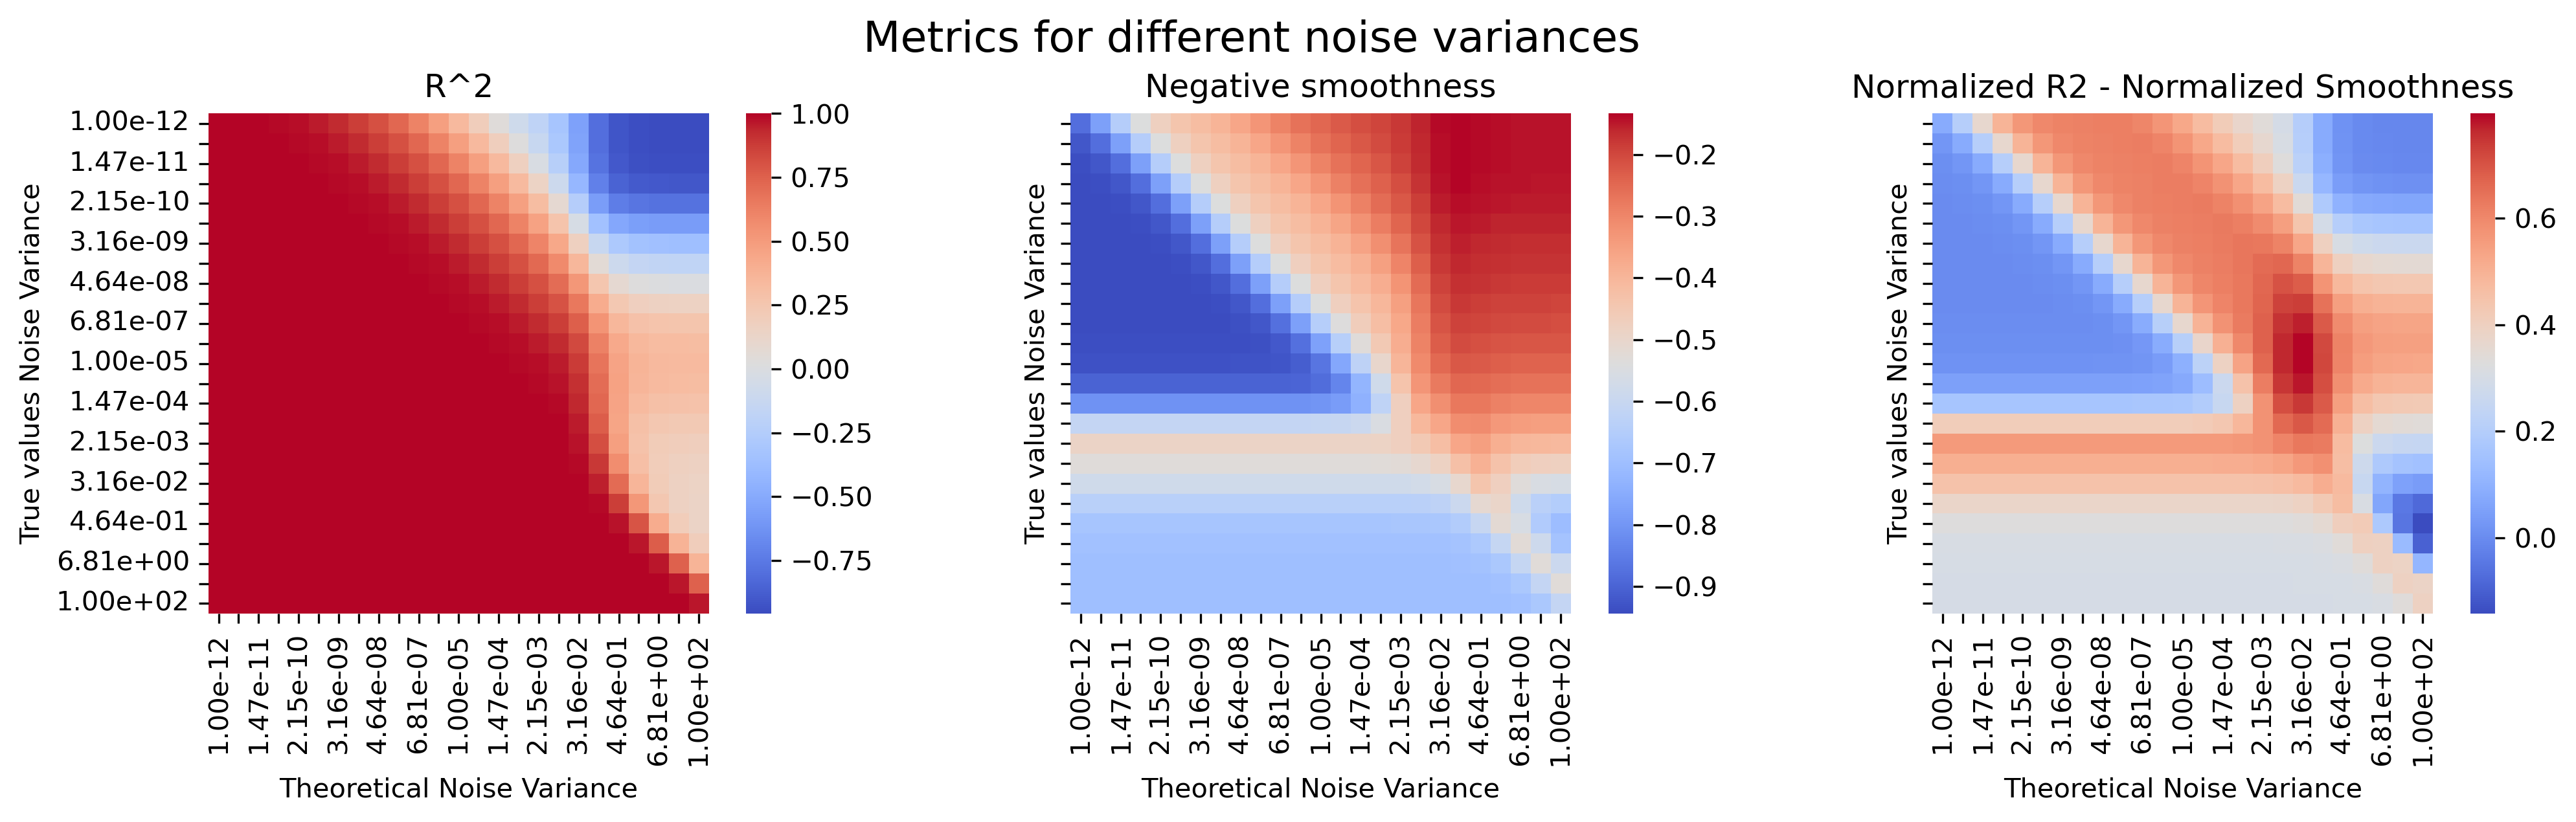

In [133]:
noise_variance_heatmap(r2s, smoothness_losses, optimal_metric, variances, file_path=results.OUTPUT_DATA_PATH + 'KF_heatmap.pdf')